In [1]:
%matplotlib inline

import os
import sys
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

import glob
import random
import cv2
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F

import roma
import kornia
import utils.colmap as colmap_utils
import utils.opt as opt_utils

from tqdm import tqdm
from copy import deepcopy
from PIL import Image
from matplotlib import pyplot as plt

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images_ratio
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

from utils.umeyama import umeyama
from utils.metric_torch import evaluate_auc, evaluate_pcd

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
torch._dynamo.config.accumulated_cache_size_limit = 512

# Run VGGT for camera and depth estimation
model = VGGT()
_URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
model.load_state_dict(torch.hub.load_state_dict_from_url(_URL))
model.eval()
model = model.to(device).to(dtype)
print(f"Model loaded")

Model loaded


In [3]:
def run_VGGT(images, device, dtype):
    # images: [B, 3, H, W]

    with torch.no_grad():
        predictions = model(images.to(device, dtype), verbose=True)
        extrinsic, intrinsic = pose_encoding_to_extri_intri(predictions['pose_enc'], images.shape[-2:])
        extrinsic = extrinsic.squeeze(0).cpu().numpy()
        intrinsic = intrinsic.squeeze(0).cpu().numpy()
        depth_map = predictions['depth'].squeeze(0).cpu().numpy()
        depth_conf = predictions['depth_conf'].squeeze(0).cpu().numpy()
        track_feats = predictions['track_feats'].squeeze(0).cpu()
    
    return extrinsic, intrinsic, depth_map, depth_conf, track_feats

In [5]:
# Get image paths and preprocess them
data_dir = "../data/MipNeRF360/stump"
sparse_dir_gt = os.path.join(data_dir, "sparse", "0")
dust_dir = os.path.join(data_dir, "mast3r")
image_dir = os.path.join(data_dir, "images")
scene = os.path.basename(data_dir)

cameras_gt = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_gt, "cameras.bin"))
images_gt = colmap_utils.read_images_binary(os.path.join(sparse_dir_gt, "images.bin"))
pcd_gt = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_gt, "points3D.bin"))
# images_gt = dict(sorted(images_gt.items(), key=lambda item: item[0]))

In [6]:
images_gt_keys = list(images_gt.keys())
random.shuffle(images_gt_keys)
images_gt_updated = {id: images_gt[id] for id in list(images_gt_keys)}
image_path_list = [os.path.join(image_dir, images_gt_updated[id].name) for id in images_gt_updated.keys()]
base_image_path_list = [os.path.basename(path) for path in image_path_list]

img_load_resolution = 518
images, original_coords = load_and_preprocess_images_ratio(image_path_list, img_load_resolution)
original_coords = original_coords.to(device)

In [7]:
extrinsic, intrinsic, depth_map, depth_conf, track_feats = run_VGGT(images, device, dtype)
torch.cuda.empty_cache()

Running patch embedding


Running attention: 100%|██████████| 24/24 [00:20<00:00,  1.19it/s]


Running camera head


/data1/jing_li/anaconda3/envs/vggt_310_bkup/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:124: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Running depth head
Running point head
Running track head


In [8]:
fl_gt = torch.tensor([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()], device=device)
translation_gt = torch.tensor([image.tvec for image in images_gt_updated.values()], device=device)
rotation_gt = torch.tensor([colmap_utils.qvec2rotmat(image.qvec) for image in images_gt_updated.values()], device=device)

# gt w2c
gt_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
gt_se3[:, :3, :3] = rotation_gt
gt_se3[:, 3, :3] = translation_gt

# pred w2c
pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
pred_se3[:, :3, :3] = torch.tensor(extrinsic[:, :3, :3], device=device)
pred_se3[:, 3, :3] = torch.tensor(extrinsic[:, :3, 3], device=device)

results = evaluate_auc(pred_se3, gt_se3, device)

    --  Umeyama Scale:  4.904647153742628
    --  Umeyama Rotation: 
 [[-0.45279128 -0.16464489  0.87628313]
 [ 0.63141573  0.63468889  0.44551565]
 [-0.62951907  0.75502452 -0.18342226]]
    --  Umeyama Translation: 
 [[-3.26931152]
 [-0.31861757]
 [ 2.37706621]]
    --  Pair Rot   Error (Deg) of Vanilla:       0.92
    --  Pair Trans Error (Deg) of Vanilla:       2.90
    --  AUC at 30: 0.9197


/tmp/ipykernel_72312/4258586071.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  fl_gt = torch.tensor([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()], device=device)


## 1. Calculate Tracking

In [19]:
@torch.inference_mode()
def vggt_extract_matches(model, extrinsic, intrinsic, depth_conf, track_feats, base_image_path_list, 
                         max_query_pts=4096, batch_size=32, conf_threshold=None, device='cuda'):
    
    track_feats = track_feats.to(device)
    pairs, pairs_cnt = opt_utils.image_pair_candidates(extrinsic, 30, unique_pairs=True)
    print("Total candidate image pairs found: ", pairs_cnt)

    indexes_i = list(range(len(base_image_path_list)-1))  # except for the last image 
    # indexes_j = [np.random.choice(pairs[idx_i], min(20, len(pairs[idx_i])), replace=False) for idx_i in indexes_i]
    indexes_j = [pairs[idx_i] for idx_i in indexes_i]
    indexes_i_updated = []
    indexes_j_updated = []

    if conf_threshold is None:
        conf_threshold = np.percentile(depth_conf, 50)
        print(f"Confidence threshold is set to {conf_threshold:.4f}")
    score_threshold = conf_threshold * 0.05
    matches_list = []

    for i in tqdm(range(0, len(indexes_i)), desc="Matching image pairs..."):
        index_j_updated = []

        for j in range(0, len(indexes_j[i]), batch_size):
            end_j = min(j + batch_size, len(indexes_j[i]))
            index = [i] + indexes_j[i][j:end_j]
            masks_src = (depth_conf[i:i+1] > conf_threshold)
            if not masks_src.any():
                continue

            valid_index = np.where(masks_src.flatten())[0].tolist()
            mark_points = np.random.choice(valid_index, min(max_query_pts, len(valid_index)), replace=False).tolist()

            query_points_list = []
            for point in mark_points:
                x, y = divmod(point, depth_conf.shape[1])
                query_points_list.append([x, y])
            query_points = torch.FloatTensor(query_points_list).to(device, dtype)

            track_list, vis_score, conf_score = model.track_head.tracker(query_points=query_points[None], 
                                                                        fmaps=track_feats[index][None], 
                                                                        iters=model.track_head.iters)
            
            valid_track_score_mask = (conf_score > score_threshold) & (vis_score > score_threshold)
            for k in range(1, len(index)):
                track_src = track_list[-1][0, 0]
                track_tgt = track_list[-1][0, k]
                track_pair = torch.cat([track_src, track_tgt], dim=-1)
                track_mask = valid_track_score_mask[0, k] & valid_track_score_mask[0, 0]
                if torch.any(track_mask):
                    matches_list.append(track_pair[track_mask])
                    index_j_updated.append(indexes_j[i][j+k-1])
        
        if len(index_j_updated) > 0:
            indexes_i_updated.append([i]*len(index_j_updated))
            indexes_j_updated.append(index_j_updated)

    num_matches = [len(m) for m in matches_list]

    indexes_i_expanded = []
    indexes_j_expanded = []

    indexes_i = np.concatenate(indexes_i_updated).tolist()
    indexes_j = np.concatenate(indexes_j_updated).tolist()

    for idx, n in enumerate(num_matches):
        indexes_i_expanded.append(np.array([indexes_i[idx]] * n, dtype=np.int64))
        indexes_j_expanded.append(np.array([indexes_j[idx]] * n, dtype=np.int64))
    indexes_i_expanded = np.concatenate(indexes_i_expanded)
    indexes_j_expanded = np.concatenate(indexes_j_expanded)

    image_names_i = np.array(base_image_path_list)[indexes_i_expanded]
    image_names_j = np.array(base_image_path_list)[indexes_j_expanded]

    corr_points_i = torch.cat([matches_list[k][:, :2] for k in range(len(matches_list))], dim=0).cpu()
    corr_points_j = torch.cat([matches_list[k][:, 2:] for k in range(len(matches_list))], dim=0).cpu()

    intrinsic_i = np.zeros((corr_points_i.shape[0], 4, 4), dtype=np.float32)
    intrinsic_j = np.zeros((corr_points_j.shape[0], 4, 4), dtype=np.float32)
    intrinsic_i[:, :3, :3] = intrinsic[indexes_i_expanded]
    intrinsic_j[:, :3, :3] = intrinsic[indexes_j_expanded]
    intrinsic_i[:, 3, 3] = 1.0
    intrinsic_j[:, 3, 3] = 1.0

    extrinsic_i = np.zeros((corr_points_i.shape[0], 4, 4), dtype=np.float32)
    extrinsic_j = np.zeros((corr_points_j.shape[0], 4, 4), dtype=np.float32)
    extrinsic_i[:, :3, :4] = extrinsic[indexes_i_expanded]
    extrinsic_j[:, :3, :4] = extrinsic[indexes_j_expanded]
    extrinsic_i[:, 3, 3] = 1.0
    extrinsic_j[:, 3, 3] = 1.0

    device = corr_points_i.device

    intrinsic_i_tensor = torch.FloatTensor(intrinsic_i).to(device)
    intrinsic_j_tensor = torch.FloatTensor(intrinsic_j).to(device)
    extrinsic_i_tensor = torch.FloatTensor(extrinsic_i).to(device)
    extrinsic_j_tensor = torch.FloatTensor(extrinsic_j).to(device)
    corr_points_i = corr_points_i.to(extrinsic_i_tensor.dtype)
    corr_points_j = corr_points_j.to(extrinsic_i_tensor.dtype)

    P_i = intrinsic_i_tensor @ extrinsic_i_tensor
    P_j = intrinsic_j_tensor @ extrinsic_j_tensor
    Fm = kornia.geometry.epipolar.fundamental_from_projections(P_i[:, :3], P_j[:, :3])
    err = kornia.geometry.symmetrical_epipolar_distance(corr_points_i[:, None, :2], corr_points_j[:, None, :2], Fm, squared=False, eps=1e-08)
    
    hist, bin_edges = torch.histogram(err.cpu(), bins=100, range=(0, 20), density=True)  # move to cpu to avoid CUDA "backend"
    corr_weights = torch.zeros_like(err)
    for i in range(len(bin_edges) - 1):
        mask = (err >= bin_edges[i]) & (err < bin_edges[i + 1])
        if torch.any(mask):
            corr_weights[mask] = (hist[i] * (bin_edges[i + 1] - bin_edges[i])) / (bin_edges[-1] - bin_edges[0])
    corr_weights /= corr_weights.mean()
    
    # set corr_weights to 0 for points outside the image frame
    in_frame_i = (corr_points_i[..., 0] > depth_conf.shape[-1]) & (corr_points_i[..., 0] < 0) & \
                    (corr_points_i[..., 1] > depth_conf.shape[-2]) & (corr_points_i[..., 1] < 0)
    in_frame_j = (corr_points_j[..., 0] > depth_conf.shape[-1]) & (corr_points_j[..., 0] < 0) & \
                    (corr_points_j[..., 1] > depth_conf.shape[-2]) & (corr_points_j[..., 1] < 0)
    corr_weights[in_frame_i & in_frame_j] = 0.0
    
    # rearrange corr_points_i_normalized and corr_points_j_normalized to (P, N, 2)
    P, N = len(num_matches), max(num_matches)
    corr_points_i_batched = torch.zeros((P, N, 2), dtype=corr_points_i.dtype, device=corr_points_i.device)
    corr_points_j_batched = torch.zeros((P, N, 2), dtype=corr_points_j.dtype, device=corr_points_j.device)
    corr_weights_batched = torch.zeros((P, N, 1), dtype=corr_weights.dtype, device=corr_weights.device)
    image_names_i_batched = np.zeros((P), dtype=image_names_i.dtype)
    image_names_j_batched = np.zeros((P), dtype=image_names_j.dtype)

    start_idx = 0
    for p in range(P):
        end_idx = start_idx + num_matches[p]
        corr_points_i_batched[p, :num_matches[p]] = corr_points_i[start_idx:end_idx]
        corr_points_j_batched[p, :num_matches[p]] = corr_points_j[start_idx:end_idx]
        corr_weights_batched[p, :num_matches[p]] = corr_weights[start_idx:end_idx]
        image_names_i_batched[p] = image_names_i[start_idx]
        image_names_j_batched[p] = image_names_j[start_idx]
        assert (image_names_i[start_idx:end_idx] == image_names_i_batched[p]).all()
        assert (image_names_j[start_idx:end_idx] == image_names_j_batched[p]).all()
        start_idx = end_idx
    
    output_dict = {
        "corr_points_i": corr_points_i_batched,
        "corr_points_j": corr_points_j_batched,
        "corr_weights": corr_weights_batched,
        "image_names_i": image_names_i_batched,
        "image_names_j": image_names_j_batched,
        "num_matches": num_matches,
        "epipolar_err": err.median().item()
    }

    return output_dict

In [20]:
target_match_dir = f"./matches_{scene}.pt"
if os.path.exists(target_match_dir):
    print(f"Found existing matches at {target_match_dir}, loading it")
    match_outputs = torch.load(target_match_dir)
else:
    max_query_pts = 4096 if len(images) < 500 else 2048
    match_outputs = vggt_extract_matches(model, extrinsic, intrinsic,depth_conf, track_feats, 
                                         base_image_path_list, max_query_pts, device=device)
    # match_outputs = opt_utils.extract_matches(extrinsic, intrinsic, images, base_image_path_list, max_query_pts)
    match_outputs["original_width"] = images.shape[-1]
    match_outputs["original_height"] = images.shape[-2]
    # torch.save(match_outputs, target_match_dir)
    # print(f"Saved matches to {target_match_dir}")

Total candidate image pairs found:  640
Confidence threshold is set to 2.1960


Matching image pairs...: 100%|██████████| 124/124 [00:37<00:00,  3.32it/s]


## 2. Optimize Pose

In [21]:
def pose_optimization(match_outputs, 
                      extrinsic, 
                      intrinsic, 
                      images, 
                      depth_map, 
                      depth_conf, 
                      base_image_path_list, 
                      device='cuda',
                      lr_base=None,
                      lr_end=None,
                      min_thr=50.0,
                      max_thr=200.0,
                      lambda_3d=0.1,
                      lambda_epi=1.0,
                      niter=300,
                      target_scene_dir=None,
                      shared_intrinsics=True):
    
    torch.cuda.empty_cache()
    
    if lr_base is None or lr_end is None:
        lr_base, lr_end = opt_utils.get_default_lr(match_outputs["epipolar_err"])
    
    with torch.no_grad():
        imsizes = torch.tensor([images.shape[-1], images.shape[-2]]).float()
        diags = torch.norm(imsizes)
        min_focals = 0.25 * diags  # diag = 1.2~1.4*max(W,H) => beta >= 1/(2*1.2*tan(fov/2)) ~= 0.26
        max_focals = 10 * diags

        qvec = roma.rotmat_to_unitquat(torch.tensor(extrinsic[:, :3, :3]))
        tvec = torch.tensor(extrinsic[:, :3, 3])
        log_sizes = torch.zeros(len(qvec))

        pps = torch.tensor(intrinsic[:, :2, 2]) / imsizes[None, :2]  # default principal_point would be (0.5, 0.5)
        base_focals = torch.tensor((intrinsic[:, 0, 0] + intrinsic[:, 1, 1]) / 2)

        # intrinsics parameters
        if shared_intrinsics:
            # Optimize a single set of intrinsics for all cameras. Use averages as init.
            confs = depth_conf.mean(axis=(1, 2))
            weighting = torch.tensor(confs / confs.sum())
            pps = weighting @ pps
            pps = pps.view(1, -1)
            focal_m = weighting @ base_focals
            log_focals = focal_m.view(1).log()
        else:
            log_focals = base_focals.log()

        corr_points_i = match_outputs["corr_points_i"].clone()
        corr_points_j = match_outputs["corr_points_j"].clone()
        corr_weights = match_outputs["corr_weights"].clone()
        num_matches = match_outputs["num_matches"]
        indexes_i = [base_image_path_list.index(img_name) for img_name in match_outputs["image_names_i"]]
        indexes_j = [base_image_path_list.index(img_name) for img_name in match_outputs["image_names_j"]]
        imsizes = imsizes.to(corr_points_i.device)
        
    qvec = qvec.to(device)
    tvec = tvec.to(device)
    log_sizes = log_sizes.to(device)
    min_focals = min_focals.to(device)
    max_focals = max_focals.to(device)
    imsizes = imsizes.to(device)
    pps = pps.to(device)
    log_focals = log_focals.to(device)

    corr_points_i = corr_points_i.to(device)
    corr_points_j = corr_points_j.to(device)
    corr_weight_valid = corr_weights.to(device)
    corr_weight_valid = corr_weight_valid**(0.5)
    corr_weight_valid /= corr_weight_valid.mean()

    params = [{
        "params": [
            qvec.requires_grad_(True), 
            tvec.requires_grad_(True), 
            log_sizes.requires_grad_(True),
            log_focals.requires_grad_(True),
            pps.requires_grad_(True)
        ],
        "name": ["qvec", "tvec", "log_sizes", "log_focals", "pps"],
    }]

    optimizer = torch.optim.Adam(params, lr=1, weight_decay=0, betas=(0.9, 0.9))
     ##### Get all the pruning thresholds #####
    thr_list = torch.linspace(
        min_thr, max_thr, niter, device=device
    )  # (num_prune_steps,)
    thr_list = thr_list.flip(0)  # (num_prune_steps,) from large to small
    thr_list = thr_list.tolist()  # list

    loss_list = []
    for iter in tqdm(range(niter or 1), desc="Pose Optimization..."):

        repeat_cnt = 1 if len(qvec) else shared_intrinsics
        
        K, (w2cam, cam2w) = opt_utils.make_K_cam_depth(log_focals.repeat(repeat_cnt), pps.repeat(repeat_cnt, 1), tvec, qvec, min_focals, max_focals, imsizes)
        
        alpha = (iter / niter)
        lr = opt_utils.cosine_schedule(alpha, lr_base, lr_end)
        opt_utils.adjust_learning_rate_by_lr(optimizer, lr)
        optimizer.zero_grad()

        Ks_i = K[indexes_i]
        Ks_j = K[indexes_j]
        w2cam_i = w2cam[indexes_i]
        w2cam_j = w2cam[indexes_j]

        loss = 0.0

        # batchify the computation to avoid OOM
        P_i = Ks_i @ w2cam_i
        P_j = Ks_j @ w2cam_j
        Fm = kornia.geometry.epipolar.fundamental_from_projections(P_i[:, :3], P_j[:, :3])
        err = kornia.geometry.symmetrical_epipolar_distance(corr_points_i, corr_points_j, Fm, squared=False, eps=1e-08)
        loss = (err * corr_weight_valid.squeeze(-1)).sum() / (corr_weight_valid > 0).sum() * lambda_epi

        loss_list.append(loss.item())

        loss.backward()
        optimizer.step()

        corr_weight_valid[corr_weight_valid > thr_list[iter]] = 0.0

        # plot error histogram
        if iter == 0 and target_scene_dir is not None:
            plt.style.use("seaborn-v0_8-whitegrid")
            plt.figure(figsize=(10, 5))
            plt.hist((err * corr_weight_valid.squeeze(-1)).reshape(-1).detach().cpu().numpy(), bins=100, color='blue', alpha=0.7)
            plt.xlabel('Epipolar Error')
            plt.ylabel('Frequency')
            plt.title('Histogram of Epipolar Errors (Before Optimization)')
            # plt.savefig(f"{target_scene_dir}/epipolar_error_hist_before.png")
            # plt.close()
    
    if target_scene_dir is not None:
        plt.style.use("seaborn-v0_8-whitegrid")
        plt.figure(figsize=(10, 5))
        plt.plot(loss_list, label='Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss Value')
        plt.title(f'Loss Curve, final loss={loss_list[-1]:.4f}')
        plt.show()
        plt.savefig(f"{target_scene_dir}/loss_curve_pose_opt.png")

    
    output_extrinsic = w2cam[:, :3, :4].detach().cpu().numpy()
    output_intrinsic = K[:, :3, :3].detach().cpu().numpy()

    return output_extrinsic, output_intrinsic

In [22]:
print(match_outputs["epipolar_err"])

2.587958335876465


Pose Optimization...: 100%|██████████| 300/300 [00:06<00:00, 49.97it/s]


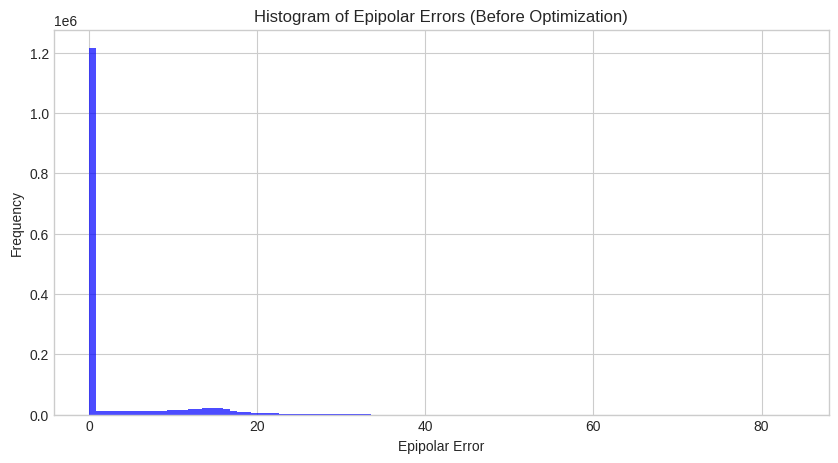

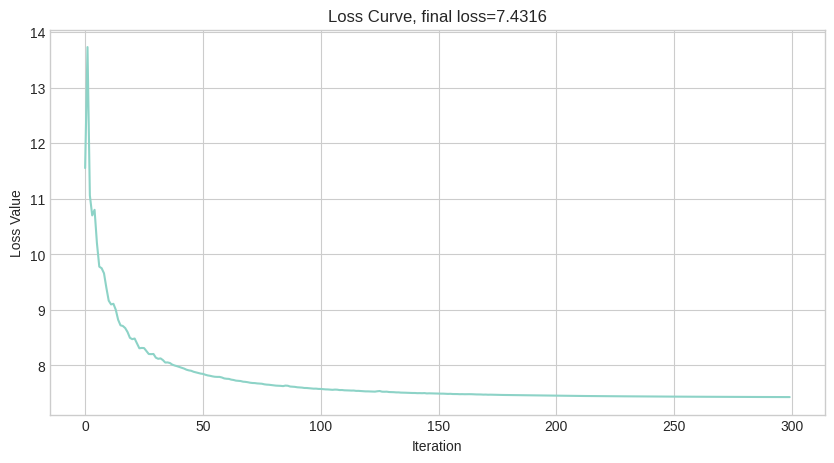

<Figure size 640x480 with 0 Axes>

In [23]:
extrinsic_, intrinsic_ = pose_optimization(
    match_outputs, extrinsic, intrinsic, images, depth_map, depth_conf,
    base_image_path_list, target_scene_dir='./', shared_intrinsics=True,
    min_thr=10.0, max_thr=100
)

In [24]:
# pred w2c
pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(extrinsic_), 1, 1)
pred_se3[:, :3, :3] = torch.tensor(extrinsic_[:, :3, :3], device=device)
pred_se3[:, 3, :3] = torch.tensor(extrinsic_[:, :3, 3], device=device)

results = evaluate_auc(pred_se3, gt_se3, device)

    --  Umeyama Scale:  4.913330622695729
    --  Umeyama Rotation: 
 [[-0.45309384 -0.16068039  0.87686247]
 [ 0.63371085  0.63375369  0.44358411]
 [-0.62699005  0.7566625  -0.18532494]]
    --  Umeyama Translation: 
 [[-3.29315404]
 [-0.34032163]
 [ 2.39905595]]
    --  Pair Rot   Error (Deg) of Vanilla:       2.39
    --  Pair Trans Error (Deg) of Vanilla:       3.59
    --  AUC at 30: 0.8807


: 